In [25]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, classification_report
import seaborn as sns

In [26]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
# == DATASET LOADING AND PREPROCESSING == #
print("Loading NusaX-Sentiment dataset...")

# Load the datasets
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('valid.csv')
test_df = pd.read_csv('test.csv')

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")

# Display dataset info
print("\nDataset columns:", train_df.columns.tolist())
print("\nFirst few training samples:")
print(train_df.head())

# Check label distribution
print("\nLabel distribution in training set:")
print(train_df['label'].value_counts())

# Prepare the data
X_train = train_df['text'].values
y_train = train_df['label'].values
X_val = valid_df['text'].values
y_val = valid_df['label'].values
X_test = test_df['text'].values
y_test = test_df['label'].values

# Create label mapping
label_mapping = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}
reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}
print(f"\nLabel mapping: {label_mapping}")

# Convert labels to numeric
y_train_numeric = np.array([label_mapping[label] for label in y_train])
y_val_numeric = np.array([label_mapping[label] for label in y_val])
y_test_numeric = np.array([label_mapping[label] for label in y_test])

num_classes = len(label_mapping)
print(f"Number of classes: {num_classes}")

Loading NusaX-Sentiment dataset...
Training samples: 500
Validation samples: 100
Test samples: 400

Dataset columns: ['id', 'text', 'label']

First few training samples:
    id                                               text     label
0  219  Nikmati cicilan 0% hingga 12 bulan untuk pemes...   neutral
1  209  Kue-kue yang disajikan bikin saya bernostalgia...  positive
2  436               Ibu pernah bekerja di grab indonesia   neutral
3  394  Paling suka banget makan siang di sini ayam sa...  positive
4  592                    Pelayanan bus DAMRI sangat baik  positive

Label distribution in training set:
label
negative    192
positive    189
neutral     119
Name: count, dtype: int64

Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}
Number of classes: 3


In [28]:
# == TEXT PREPROCESSING == #
print("\nSetting up text preprocessing...")

# Define preprocessing parameters
MAX_FEATURES = 10000  # Size of vocabulary
MAX_LENGTH = 100      # Maximum sequence length
EMBEDDING_DIM = 128   # Embedding dimension

# Create TextVectorization layer
vectorizer = layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    output_sequence_length=MAX_LENGTH,
    output_mode='int'
)

# Adapt the vectorizer to the training data
vectorizer.adapt(X_train)

# Transform text data to sequences
X_train_seq = vectorizer(X_train)
X_val_seq = vectorizer(X_val)
X_test_seq = vectorizer(X_test)

print(f"Vocabulary size: {len(vectorizer.get_vocabulary())}")
print(f"Sequence shape: {X_train_seq.shape}")



Setting up text preprocessing...
Vocabulary size: 2836
Sequence shape: (500, 100)


In [29]:
# == MODEL BUILDING FUNCTIONS == #
def create_rnn_model(num_rnn_layers=1, rnn_units=[128], bidirectional=True, embedding_dim=EMBEDDING_DIM):
    """
    Creates an RNN model based on the given parameters.
    Args:
        num_rnn_layers: Number of RNN layers
        rnn_units: List of units for each RNN layer
        bidirectional: Whether to use bidirectional RNN
        embedding_dim: Dimension of embedding layer
    Returns:
        Compiled Keras model
    """
    model = keras.Sequential()

    # Embedding layer
    model.add(layers.Embedding(
        input_dim=MAX_FEATURES,
        output_dim=embedding_dim,
        input_length=MAX_LENGTH
    ))

    # Add RNN layers
    for i in range(min(num_rnn_layers, len(rnn_units))):
        return_sequences = (i < num_rnn_layers - 1)  # Return sequences for all but last layer

        if bidirectional:
            model.add(layers.Bidirectional(
                layers.SimpleRNN(
                    units=rnn_units[i],
                    return_sequences=return_sequences,
                    dropout=0.2,
                    recurrent_dropout=0.2
                )
            ))
        else:
            model.add(layers.SimpleRNN(
                units=rnn_units[i],
                return_sequences=return_sequences,
                dropout=0.2,
                recurrent_dropout=0.2
            ))

    # Add dropout layer
    model.add(layers.Dropout(0.5))

    # Dense output layer
    model.add(layers.Dense(num_classes))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

# Custom F1 Score callback
class MacroF1Score(keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MacroF1Score, self).__init__()
        self.validation_data = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        f1 = f1_score(y_val, y_pred_classes, average='macro')
        self.f1_scores.append(f1)
        print(f" - val_f1_score: {f1:.4f}")

def train_and_evaluate_model(model, epochs=10, batch_size=64):
    """
    Trains and evaluates a model.
    Args:
        model: Compiled Keras model
        epochs: Number of training epochs
        batch_size: Batch size for training
    Returns:
        history: Training history
        f1_callback: F1 score callback with validation scores
        test_f1: Test F1 score
    """
    # Create callback for F1 score
    f1_callback = MacroF1Score(validation_data=(X_val_seq, y_val_numeric))

    # Train the model
    history = model.fit(
        X_train_seq, y_train_numeric,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val_seq, y_val_numeric),
        callbacks=[f1_callback],
        verbose=1
    )

    # Evaluate on test set
    y_pred = model.predict(X_test_seq)
    y_pred_classes = np.argmax(y_pred, axis=1)
    test_f1 = f1_score(y_test_numeric, y_pred_classes, average='macro')
    print(f"Test Macro F1 Score: {test_f1:.4f}")

    return history, f1_callback.f1_scores, test_f1

def plot_training_history(history, title="Training History", include_f1=None):
    """
    Plots the training history.
    Args:
        history: Training history from model.fit
        title: Title for the plot
        include_f1: List of F1 scores to plot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')

    # Plot F1 score if provided
    if include_f1 is not None:
        epochs = len(include_f1)
        ax2.plot(range(epochs), include_f1, label='Validation Macro F1')

    ax2.set_title(f'{title} - Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Metric Value')
    ax2.legend()

    plt.tight_layout()
    return fig



=== Experiment a: Varying Number of RNN Layers ===

Training model with 1 RNN layer(s)...
Model architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.3151 - loss: 1.2627

 - val_f1_score: 0.1814
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 787ms/step - accuracy: 0.3161 - loss: 1.2620 - val_accuracy: 0.3700 - val_loss: 1.1194
Epoch 2/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3719 - loss: 1.2106 - val_f1_score: 0.3540
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3728 - loss: 1.2057 - val_accuracy: 0.3900 - val_loss: 1.1090
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3585 - loss: 1.2198 - val_f1_score: 0.2370
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3602 - loss: 1.2140 - val_accuracy: 0.3400 - val_loss: 1.0987
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4334 - loss: 1.1557 - val_f1_score: 0.2330
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4255 - loss: 1.1599 - val_accuracy: 0.3400 - val_loss: 1.0843
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3982 - loss: 1.1691 - val_f1_score: 0.1849
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3977 - loss: 1.1679 - val_accuracy: 0.3800

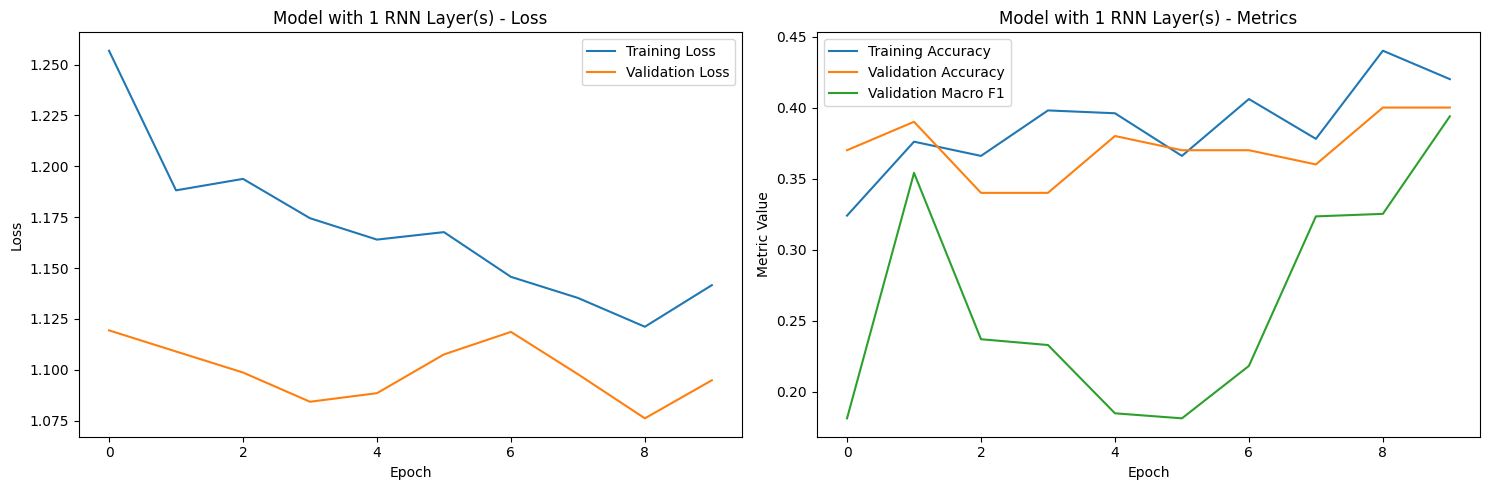


Training model with 2 RNN layer(s)...
Model architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.3150 - loss: 1.3727 - val_f1_score: 0.1980
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3153 - loss: 1.3710 - val_accuracy: 0.3800 - val_loss: 1.1266
Epoch 2/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3787 - loss: 1.2310 - val_f1_score: 0.3399
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.3736 - loss: 1.2425 - val_accuracy: 0.4500 - val_loss: 1.1334
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3763 - loss: 1.2048 - val_f1_score: 0.2772
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3775 - loss: 1.2087 - val_accuracy: 0.4300 - val_loss: 1.0663
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3751 - loss: 1.2357 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3731 - loss: 1.2422 - val_accuracy: 0.3800 - val_loss: 1.1064
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3527 - loss: 1.2471 - val_f1_score: 0.2121
8/8 ━━━━━━━━━━

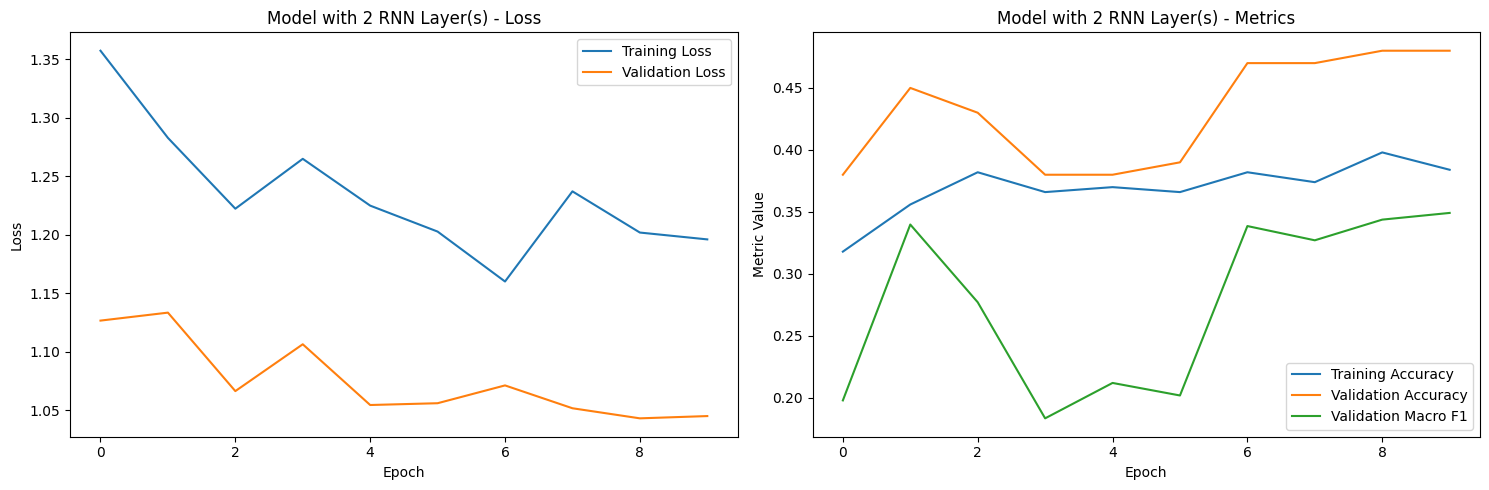


Training model with 3 RNN layer(s)...
Model architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.3605 - loss: 1.3772 - val_f1_score: 0.2277
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.3593 - loss: 1.3795 - val_accuracy: 0.3900 - val_loss: 1.1504
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3863 - loss: 1.3381 - val_f1_score: 0.2607
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.3836 - loss: 1.3396 - val_accuracy: 0.3500 - val_loss: 1.1318
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3268 - loss: 1.4820 - val_f1_score: 0.2475
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3250 - loss: 1.4866 - val_accuracy: 0.4100 - val_loss: 1.1156
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3452 - loss: 1.4049 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.3452 - loss: 1.4039 - val_accuracy: 0.3800 - val_loss: 1.1025
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3868 - loss: 1.3672 - val_f1_score: 0.1778
8/8 ━━━━━━━━━━

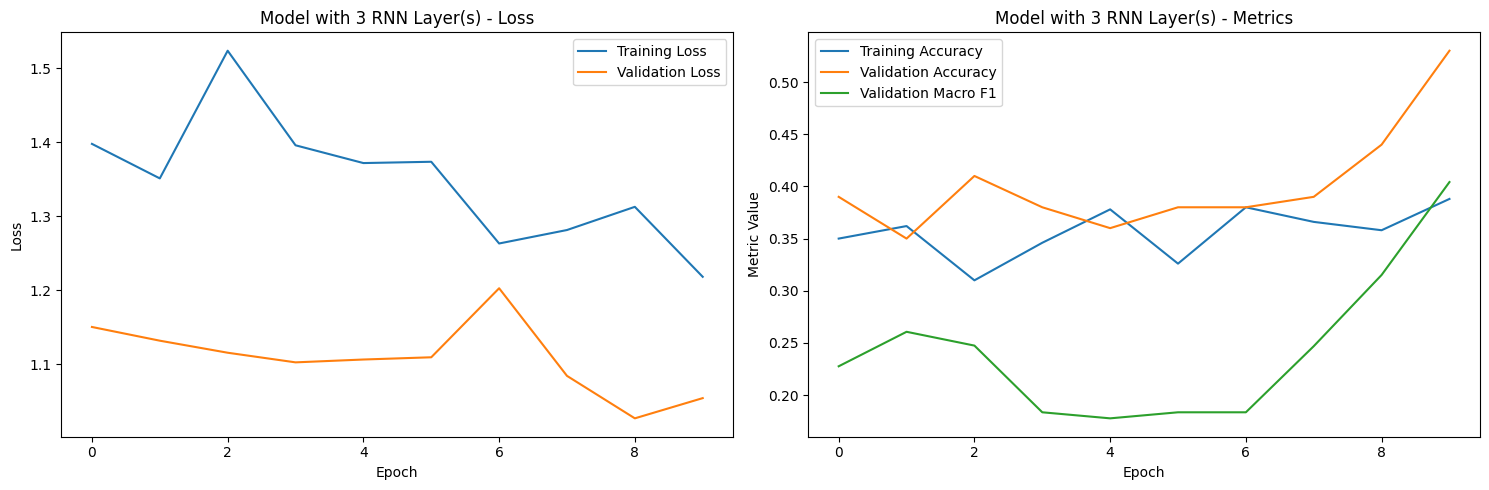

In [30]:
# == EXPERIMENT EXECUTION == #

# a. VARYING NUMBER OF RNN LAYERS
print("\n=== Experiment a: Varying Number of RNN Layers ===")
rnn_layer_results = []

for num_layers in [1, 2, 3]:
    print(f"\nTraining model with {num_layers} RNN layer(s)...")
    model = create_rnn_model(
        num_rnn_layers=num_layers,
        rnn_units=[128] * num_layers,
        bidirectional=True
    )

    print(f"Model architecture:")
    model.summary()

    history, f1_scores, test_f1 = train_and_evaluate_model(model, epochs=10)

    rnn_layer_results.append({
        'num_layers': num_layers,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })

    # Plot the training history
    plot_training_history(
        history,
        title=f"Model with {num_layers} RNN Layer(s)",
        include_f1=f1_scores
    )
    plt.show()


=== Experiment b: Varying Number of RNN Units ===

Training model with RNN units: 64-64
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.3302 - loss: 1.3284 - val_f1_score: 0.2405
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3300 - loss: 1.3279 - val_accuracy: 0.3300 - val_loss: 1.1154
Epoch 2/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3986 - loss: 1.2328 - val_f1_score: 0.2395
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.3949 - loss: 1.2470 - val_accuracy: 0.3600 - val_loss: 1.1150
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4060 - loss: 1.1955 - val_f1_score: 0.3002
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3945 - loss: 1.2116 - val_accuracy: 0.4000 - val_loss: 1.0832
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3587 - loss: 1.2956 - val_f1_score: 0.3328
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3612 - loss: 1.2840 - val_accuracy: 0.4400 - val_loss: 1.0736
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3791 - loss: 1.1948 - val_f1_score: 0.3102
8/8 ━━━━━━━━━━━━━━━━━━━━ 

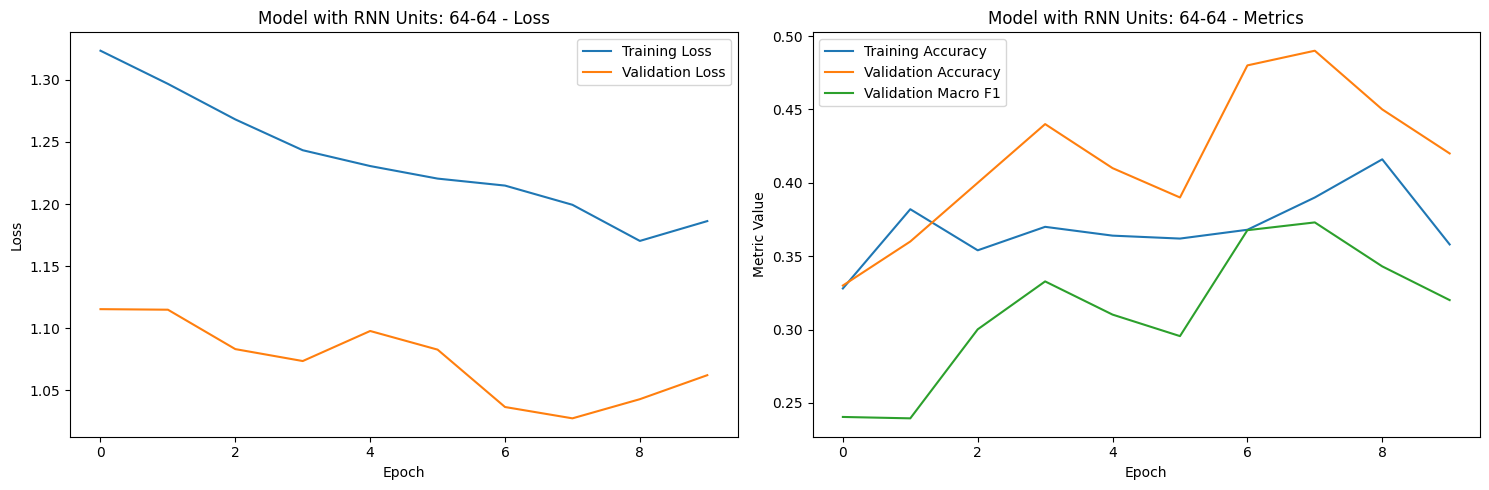


Training model with RNN units: 128-128
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.3482 - loss: 1.3479 - val_f1_score: 0.2542
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3464 - loss: 1.3475 - val_accuracy: 0.3300 - val_loss: 1.1433
Epoch 2/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3470 - loss: 1.2874 - val_f1_score: 0.2158
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.3570 - loss: 1.2773 - val_accuracy: 0.3000 - val_loss: 1.1192
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4100 - loss: 1.2195 - val_f1_score: 0.3770
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4091 - loss: 1.2161 - val_accuracy: 0.4600 - val_loss: 1.0613
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3673 - loss: 1.2733 - val_f1_score: 0.2570
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.3692 - loss: 1.2738 - val_accuracy: 0.4100 - val_loss: 1.0730
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3858 - loss: 1.2345 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 

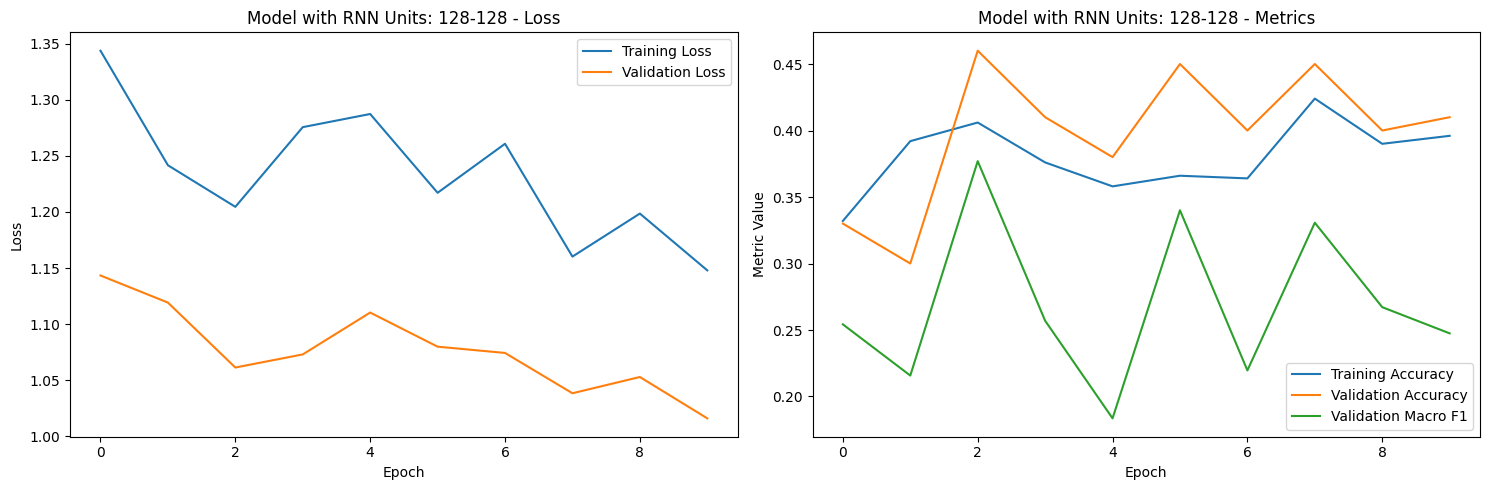


Training model with RNN units: 256-256
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.2995 - loss: 1.5224 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.2991 - loss: 1.5170 - val_accuracy: 0.3800 - val_loss: 1.2232
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3648 - loss: 1.3157 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.3636 - loss: 1.3199 - val_accuracy: 0.3800 - val_loss: 1.0926
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3677 - loss: 1.2766 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.3673 - loss: 1.2733 - val_accuracy: 0.3800 - val_loss: 1.1546
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3547 - loss: 1.2627 - val_f1_score: 0.2020
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.3568 - loss: 1.2689 - val_accuracy: 0.3900 - val_loss: 1.0716
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3724 - loss: 1.2319 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 

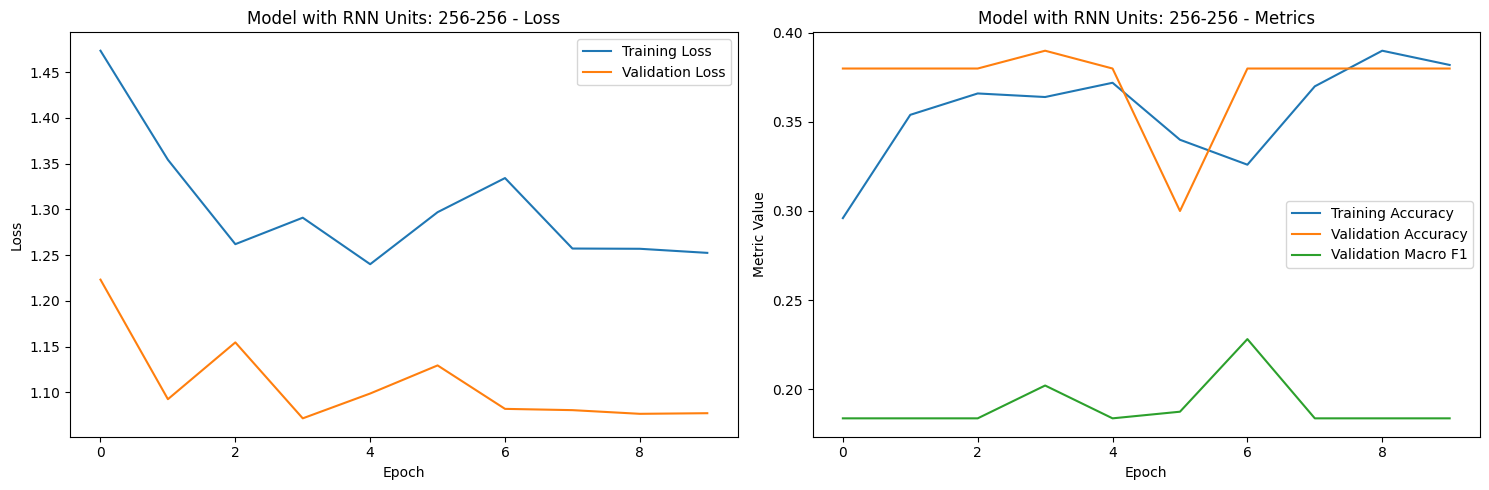

In [31]:
# b. VARYING NUMBER OF RNN UNITS
print("\n=== Experiment b: Varying Number of RNN Units ===")
units_results = []
units_configs = [
    [64, 64],
    [128, 128],
    [256, 256]
]

for units in units_configs:
    units_str = '-'.join(map(str, units))
    print(f"\nTraining model with RNN units: {units_str}")

    model = create_rnn_model(
        num_rnn_layers=len(units),
        rnn_units=units,
        bidirectional=True
    )

    history, f1_scores, test_f1 = train_and_evaluate_model(model, epochs=10)

    units_results.append({
        'units': units,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })

    # Plot the training history
    plot_training_history(
        history,
        title=f"Model with RNN Units: {units_str}",
        include_f1=f1_scores
    )
    plt.show()



=== Experiment c: Varying RNN Direction ===

Training model with Bidirectional RNN...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.3630 - loss: 1.3197 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3640 - loss: 1.3195 - val_accuracy: 0.3800 - val_loss: 1.2034
Epoch 2/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3858 - loss: 1.3698 - val_f1_score: 0.3335
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.3854 - loss: 1.3614 - val_accuracy: 0.4400 - val_loss: 1.1136
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3746 - loss: 1.2616 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3696 - loss: 1.2646 - val_accuracy: 0.3800 - val_loss: 1.1655
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3576 - loss: 1.3528 - val_f1_score: 0.2020
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3644 - loss: 1.3388 - val_accuracy: 0.3900 - val_loss: 1.1129
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4004 - loss: 1.1814 - val_f1_score: 0.3411
8/8 ━━━━━━━━━━━━━━━━━━━━

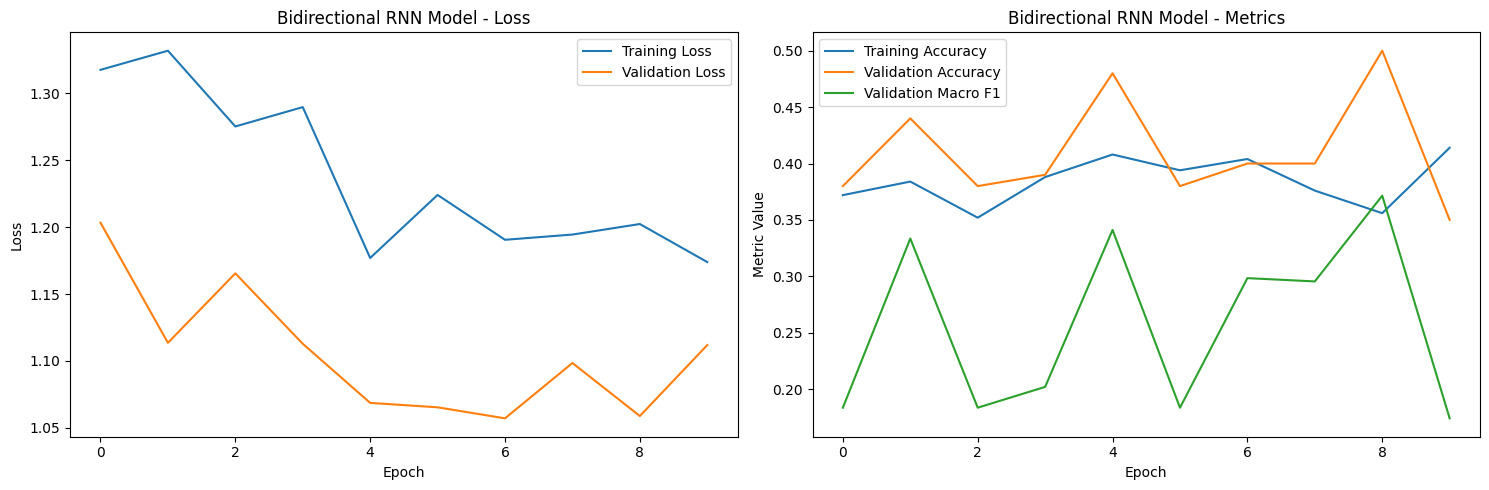


Training model with Unidirectional RNN...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.2768 - loss: 1.5149 - val_f1_score: 0.2268
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 924ms/step - accuracy: 0.2787 - loss: 1.5109 - val_accuracy: 0.3500 - val_loss: 1.1063
Epoch 2/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3795 - loss: 1.3747 - val_f1_score: 0.2975
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.3734 - loss: 1.3713 - val_accuracy: 0.4300 - val_loss: 1.1002
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3225 - loss: 1.3206 - val_f1_score: 0.1800
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3206 - loss: 1.3258 - val_accuracy: 0.3700 - val_loss: 1.1246
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3589 - loss: 1.2896 - val_f1_score: 0.2020
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3556 - loss: 1.2912 - val_accuracy: 0.3900 - val_loss: 1.0856
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3660 - loss: 1.2430 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━

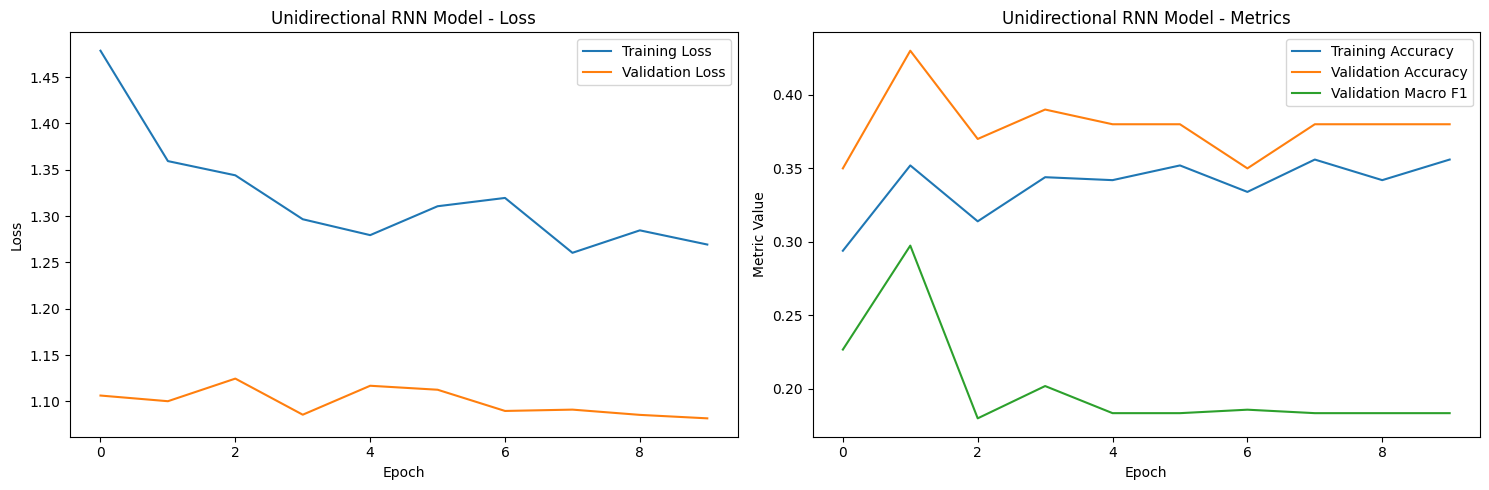

In [32]:
# c. VARYING RNN DIRECTION (Bidirectional vs Unidirectional)
print("\n=== Experiment c: Varying RNN Direction ===")
direction_results = []

for bidirectional in [True, False]:
    direction_name = "Bidirectional" if bidirectional else "Unidirectional"
    print(f"\nTraining model with {direction_name} RNN...")

    model = create_rnn_model(
        num_rnn_layers=2,
        rnn_units=[128, 128],
        bidirectional=bidirectional
    )

    history, f1_scores, test_f1 = train_and_evaluate_model(model, epochs=10)

    direction_results.append({
        'bidirectional': bidirectional,
        'direction_name': direction_name,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })

    # Plot the training history
    plot_training_history(
        history,
        title=f"{direction_name} RNN Model",
        include_f1=f1_scores
    )
    plt.show()

In [33]:
# == RESULTS ANALYSIS == #
print("\n=== Results Summary ===")

# a. Number of RNN Layers Results
print("\nNumber of RNN Layers:")
for result in rnn_layer_results:
    print(f"Layers: {result['num_layers']} - Test F1: {result['test_f1']:.4f}")

# b. Number of RNN Units Results
print("\nNumber of RNN Units:")
for result in units_results:
    units_str = '-'.join(map(str, result['units']))
    print(f"Units: {units_str} - Test F1: {result['test_f1']:.4f}")

# c. RNN Direction Results
print("\nRNN Direction:")
for result in direction_results:
    print(f"Direction: {result['direction_name']} - Test F1: {result['test_f1']:.4f}")



=== Results Summary ===

Number of RNN Layers:
Layers: 1 - Test F1: 0.4037
Layers: 2 - Test F1: 0.3023
Layers: 3 - Test F1: 0.3572

Number of RNN Units:
Units: 64-64 - Test F1: 0.2968
Units: 128-128 - Test F1: 0.2612
Units: 256-256 - Test F1: 0.1827

RNN Direction:
Direction: Bidirectional - Test F1: 0.2212
Direction: Unidirectional - Test F1: 0.1844


In [34]:
# == SAVE THE BEST MODEL == #
# Find the model with the highest test F1 score
all_results = rnn_layer_results + units_results + direction_results
best_result = max(all_results, key=lambda x: x['test_f1'])

# Create and train the best model for saving
print("\n=== Training Best Model for Saving ===")
if 'num_layers' in best_result:
    print(f"Best model: {best_result['num_layers']} RNN layers")
    best_model = create_rnn_model(
        num_rnn_layers=best_result['num_layers'],
        rnn_units=[128] * best_result['num_layers'],
        bidirectional=True
    )
elif 'units' in best_result:
    units_str = '-'.join(map(str, best_result['units']))
    print(f"Best model: RNN units {units_str}")
    best_model = create_rnn_model(
        num_rnn_layers=len(best_result['units']),
        rnn_units=best_result['units'],
        bidirectional=True
    )
else:  # 'bidirectional' in best_result
    print(f"Best model: {best_result['direction_name']} RNN")
    best_model = create_rnn_model(
        num_rnn_layers=2,
        rnn_units=[128, 128],
        bidirectional=best_result['bidirectional']
    )

# Train the best model
history, f1_scores, test_f1 = train_and_evaluate_model(best_model, epochs=15)
print(f"Best model test F1 Score: {test_f1:.4f}")

# Save the best model and vectorizer
best_model.save('best_rnn_model.h5')
print("Best model saved to 'best_rnn_model.h5'")

# Save the vectorizer weights for later use
import pickle
vectorizer_config = vectorizer.get_config()
vectorizer_weights = vectorizer.get_weights()
with open('vectorizer_config.pkl', 'wb') as f:
    pickle.dump({'config': vectorizer_config, 'weights': vectorizer_weights}, f)
print("Vectorizer saved to 'vectorizer_config.pkl'")



=== Training Best Model for Saving ===
Best model: 1 RNN layers
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.3861 - loss: 1.1850 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 907ms/step - accuracy: 0.3832 - loss: 1.1895 - val_accuracy: 0.3800 - val_loss: 1.1056
Epoch 2/15
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3448 - loss: 1.2131 - val_f1_score: 0.3445
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3410 - loss: 1.2241 - val_accuracy: 0.3700 - val_loss: 1.0840
Epoch 3/15
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3678 - loss: 1.2062 - val_f1_score: 0.1980
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3710 - loss: 1.2088 - val_accuracy: 0.3800 - val_loss: 1.0936
Epoch 4/15
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2992 - loss: 1.2834 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3025 - loss: 1.2762 - val_accuracy: 0.3800 - val_loss: 1.0963
Epoch 5/15
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3769 - loss: 1.1624 - val_f1_score: 0.3569
8/8 ━━━━━━━━━━━━━━━━━━

Test Macro F1 Score: 0.3282
Best model test F1 Score: 0.3282
Best model saved to 'best_rnn_model.h5'
Vectorizer saved to 'vectorizer_config.pkl'


In [35]:
# == CONCLUSIONS == #
print("\n=== Experiment Conclusions ===")

# a. Number of RNN Layers
print("\nEffect of Number of RNN Layers:")
max_rnn_layer = max(rnn_layer_results, key=lambda x: x['test_f1'])
print(f"Best number of RNN layers: {max_rnn_layer['num_layers']} (F1: {max_rnn_layer['test_f1']:.4f})")
print("Conclusion: Adding more RNN layers can help capture more complex patterns in sequential data,")
print("            but too many layers may lead to vanishing gradient problems and overfitting.")

# b. Number of RNN Units
print("\nEffect of Number of RNN Units:")
max_units = max(units_results, key=lambda x: x['test_f1'])
units_str = '-'.join(map(str, max_units['units']))
print(f"Best RNN units configuration: {units_str} (F1: {max_units['test_f1']:.4f})")
print("Conclusion: Increasing RNN units improves the model's capacity to learn complex representations,")
print("            but with diminishing returns and increased computational cost.")

# c. RNN Direction
print("\nEffect of RNN Direction:")
max_direction = max(direction_results, key=lambda x: x['test_f1'])
print(f"Best RNN direction: {max_direction['direction_name']} (F1: {max_direction['test_f1']:.4f})")
print("Conclusion: Bidirectional RNNs can access both past and future context, often improving performance")
print("            for text classification tasks, while unidirectional RNNs are simpler and faster.")

# Summary
print("\nOverall Conclusion:")
print("The experiments demonstrate that RNN architecture choices significantly impact text classification performance.")
print("For sentiment analysis on Indonesian text, we found that the right balance of depth, width, and direction")
print("is crucial for optimal performance. The saved model represents our best configuration based on Macro F1 score.")



=== Experiment Conclusions ===

Effect of Number of RNN Layers:
Best number of RNN layers: 1 (F1: 0.4037)
Conclusion: Adding more RNN layers can help capture more complex patterns in sequential data,
            but too many layers may lead to vanishing gradient problems and overfitting.

Effect of Number of RNN Units:
Best RNN units configuration: 64-64 (F1: 0.2968)
Conclusion: Increasing RNN units improves the model's capacity to learn complex representations,
            but with diminishing returns and increased computational cost.

Effect of RNN Direction:
Best RNN direction: Bidirectional (F1: 0.2212)
Conclusion: Bidirectional RNNs can access both past and future context, often improving performance
            for text classification tasks, while unidirectional RNNs are simpler and faster.

Overall Conclusion:
The experiments demonstrate that RNN architecture choices significantly impact text classification performance.
For sentiment analysis on Indonesian text, we found that t

In [45]:
# == FORWARD PROPAGATION FROM SCRATCH == #
class Embedding:
    def __init__(self, weights):
        """
        Initialize an Embedding layer with pre-trained weights.
        Args:
            weights: Pre-trained embedding weights with shape (vocab_size, embedding_dim)
        """
        self.weights = weights
        self.vocab_size, self.embedding_dim = weights.shape

    def forward(self, inputs):
        """
        Forward pass for Embedding layer.
        Args:
            inputs: Input tensor with shape (batch_size, sequence_length) containing token indices
        Returns:
            Output tensor with shape (batch_size, sequence_length, embedding_dim)
        """
        batch_size, sequence_length = inputs.shape
        outputs = np.zeros((batch_size, sequence_length, self.embedding_dim))
        for b in range(batch_size):
            for t in range(sequence_length):
                token_idx = int(inputs[b, t])
                if token_idx < self.vocab_size:
                    outputs[b, t] = self.weights[token_idx]
        return outputs

class SimpleRNN:
    def __init__(self, kernel, recurrent_kernel, bias):
        """
        Initialize a SimpleRNN layer with pre-trained weights.
        Args:
            kernel: Input-to-hidden weights with shape (input_dim, units)
            recurrent_kernel: Hidden-to-hidden weights with shape (units, units)
            bias: Bias weights with shape (units,)
        """
        self.kernel = kernel
        self.recurrent_kernel = recurrent_kernel
        self.bias = bias
        self.units = kernel.shape[1]
        print(f"    SimpleRNN initialized with kernel: {kernel.shape}, recurrent: {recurrent_kernel.shape}, bias: {bias.shape}")

    def forward(self, inputs, return_sequences=False):
        """
        Forward pass for SimpleRNN layer.
        Args:
            inputs: Input tensor with shape (batch_size, sequence_length, input_dim)
            return_sequences: Whether to return all timestep outputs or just the last
        Returns:
            Output tensor with shape (batch_size, units) or (batch_size, sequence_length, units)
        """
        batch_size, sequence_length, input_dim = inputs.shape
        # Initialize hidden state
        h = np.zeros((batch_size, self.units))

        if return_sequences:
            outputs = np.zeros((batch_size, sequence_length, self.units))

        # Process each timestep
        for t in range(sequence_length):
            # Input at current timestep
            x_t = inputs[:, t, :]  # (batch_size, input_dim)
            # Compute new hidden state: h_t = tanh(W_ih * x_t + W_hh * h_{t-1} + b)
            h = np.tanh(np.dot(x_t, self.kernel) + np.dot(h, self.recurrent_kernel) + self.bias)

            if return_sequences:
                outputs[:, t, :] = h

        if return_sequences:
            return outputs
        else:
            return h

class BidirectionalRNN:
    def __init__(self, forward_rnn, backward_rnn):
        """
        Initialize a Bidirectional RNN layer.
        Args:
            forward_rnn: Forward RNN layer
            backward_rnn: Backward RNN layer
        """
        self.forward_rnn = forward_rnn
        self.backward_rnn = backward_rnn
        print(f"    Bidirectional RNN initialized with forward units: {forward_rnn.units}, backward units: {backward_rnn.units}")

    def forward(self, inputs, return_sequences=False):
        """
        Forward pass for Bidirectional RNN.
        Args:
            inputs: Input tensor with shape (batch_size, sequence_length, input_dim)
            return_sequences: Whether to return all timestep outputs or just the last
        Returns:
            Output tensor with concatenated forward and backward outputs
        """
        # Forward pass
        forward_output = self.forward_rnn.forward(inputs, return_sequences=return_sequences)

        # Backward pass (reverse the sequence)
        reversed_inputs = inputs[:, ::-1, :]  # Reverse time dimension
        backward_output = self.backward_rnn.forward(reversed_inputs, return_sequences=return_sequences)

        if return_sequences:
            # Reverse the backward output to align with forward output
            backward_output = backward_output[:, ::-1, :]
            # Concatenate along the last dimension
            output = np.concatenate([forward_output, backward_output], axis=-1)
        else:
            # Concatenate the final outputs
            output = np.concatenate([forward_output, backward_output], axis=-1)

        return output

class RNNDropout:
    def __init__(self, rate):
        """
        Initialize a Dropout layer.
        Args:
            rate: Dropout rate
        """
        self.rate = rate

    def forward(self, inputs):
        """
        Forward pass for Dropout layer. During inference, just return the inputs.
        Args:
            inputs: Input tensor
        Returns:
            Output tensor
        """
        # For inference, we don't apply dropout
        return inputs

class RNNDense:
    def __init__(self, weights, biases):
        """
        Initialize a Dense layer with pre-trained weights and biases.
        Args:
            weights: Pre-trained weights with shape (input_dim, output_dim)
            biases: Pre-trained biases with shape (output_dim,)
        """
        self.weights = weights
        self.biases = biases
        print(f"    Dense layer initialized with weights: {weights.shape}, biases: {biases.shape}")

    def forward(self, inputs):
        """
        Forward pass for Dense layer.
        Args:
            inputs: Input tensor with shape (batch_size, input_dim)
        Returns:
            Output tensor with shape (batch_size, output_dim) - RAW LOGITS (no activation)
        """
        return np.dot(inputs, self.weights) + self.biases

class RNNModel:
    def __init__(self):
        """
        Initialize the RNN model with empty layers list.
        """
        self.layers = []

    def add_layer(self, layer):
        """
        Add a layer to the model.
        Args:
            layer: Layer object with a forward method
        """
        self.layers.append(layer)

    def forward(self, inputs):
        """
        Forward pass for the RNN model.
        Args:
            inputs: Input tensor
        Returns:
            Output tensor after forward propagation through all layers (RAW LOGITS)
        """
        outputs = inputs
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'forward'):
                if isinstance(layer, (SimpleRNN, BidirectionalRNN)):
                    # Check if this is the last RNN layer (next layer is not RNN)
                    next_layer_is_rnn = (i + 1 < len(self.layers) and
                                       isinstance(self.layers[i + 1], (SimpleRNN, BidirectionalRNN)))
                    return_sequences = next_layer_is_rnn
                    outputs = layer.forward(outputs, return_sequences=return_sequences)
                else:
                    outputs = layer.forward(outputs)
                print(f"    After layer {i} ({layer.__class__.__name__}): shape {outputs.shape}, range [{np.min(outputs):.4f}, {np.max(outputs):.4f}]")
        return outputs

    def predict(self, inputs, batch_size=32):
        """
        Make predictions for input data.
        Args:
            inputs: Input data with shape (num_samples, sequence_length)
            batch_size: Batch size for prediction
        Returns:
            Predictions with shape (num_samples, num_classes) - RAW LOGITS
        """
        num_samples = inputs.shape[0]
        num_batches = (num_samples + batch_size - 1) // batch_size
        predictions = []

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            batch_inputs = inputs[start_idx:end_idx]
            batch_predictions = self.forward(batch_inputs)
            predictions.append(batch_predictions)

        return np.vstack(predictions)

def print_keras_model_layers(keras_model):
    """
    Print detailed information about Keras model layers.
    """
    print("\n=== Keras Model Layer Information ===")
    for i, layer in enumerate(keras_model.layers):
        print(f"Layer {i}: {layer.name} ({layer.__class__.__name__})")
        print(f"  Config keys: {list(layer.get_config().keys())}")

        # Try to get weights
        try:
            weights = layer.get_weights()
            print(f"  Number of weight matrices: {len(weights)}")
            for j, w in enumerate(weights):
                print(f"    Weight {j}: {w.shape}")
        except:
            print(f"  No weights available")

        # Special handling for bidirectional layers
        if hasattr(layer, 'forward_layer'):
            print(f"  Has 'forward_layer' attribute: {layer.forward_layer}")
        if hasattr(layer, 'backward_layer'):
            print(f"  Has 'backward_layer' attribute: {layer.backward_layer}")

        print()  # Empty line for readability

def build_rnn_from_keras(keras_model):
    """
    Build a custom RNN model from a Keras model with improved weight extraction.
    Args:
        keras_model: Pre-trained Keras model
    Returns:
        Custom RNN model
    """
    custom_model = RNNModel()

    # Print layer information first
    print_keras_model_layers(keras_model)

    # Iterate through all layers of the Keras model
    for i, layer in enumerate(keras_model.layers):
        layer_class = layer.__class__.__name__
        print(f"Processing layer {i}: {layer.name} ({layer_class})")

        if layer_class == 'Embedding':
            # Get embedding weights
            weights = layer.get_weights()[0]
            print(f"  Embedding shape: {weights.shape}")
            custom_model.add_layer(Embedding(weights=weights))

        elif layer_class == 'Bidirectional':
            # Handle bidirectional RNN
            weights = layer.get_weights()
            print(f"  Found {len(weights)} weight matrices")
            print(f"  Weight shapes: {[w.shape for w in weights]}")

            # For Keras Bidirectional SimpleRNN, weights are typically ordered as:
            # [forward_kernel, forward_recurrent_kernel, forward_bias,
            #  backward_kernel, backward_recurrent_kernel, backward_bias]
            if len(weights) >= 6:
                forward_kernel = weights[0]        # (input_dim, units)
                forward_recurrent_kernel = weights[1]  # (units, units)
                forward_bias = weights[2]          # (units,)
                backward_kernel = weights[3]       # (input_dim, units)
                backward_recurrent_kernel = weights[4]  # (units, units)
                backward_bias = weights[5]         # (units,)

                print(f"  Forward RNN - kernel: {forward_kernel.shape}, recurrent: {forward_recurrent_kernel.shape}, bias: {forward_bias.shape}")
                print(f"  Backward RNN - kernel: {backward_kernel.shape}, recurrent: {backward_recurrent_kernel.shape}, bias: {backward_bias.shape}")

                # Create forward and backward RNN layers
                forward_rnn = SimpleRNN(forward_kernel, forward_recurrent_kernel, forward_bias)
                backward_rnn = SimpleRNN(backward_kernel, backward_recurrent_kernel, backward_bias)

                # Create bidirectional layer
                custom_model.add_layer(BidirectionalRNN(forward_rnn, backward_rnn))
            else:
                print(f"  Warning: Expected 6 weight matrices for bidirectional RNN, got {len(weights)}")

        elif layer_class == 'SimpleRNN':
            # Handle unidirectional SimpleRNN
            weights = layer.get_weights()
            if len(weights) >= 3:
                kernel = weights[0]           # (input_dim, units)
                recurrent_kernel = weights[1] # (units, units)
                bias = weights[2]             # (units,)
                print(f"  SimpleRNN - kernel: {kernel.shape}, recurrent: {recurrent_kernel.shape}, bias: {bias.shape}")
                custom_model.add_layer(SimpleRNN(kernel, recurrent_kernel, bias))
            else:
                print(f"  Warning: Expected 3 weight matrices for SimpleRNN, got {len(weights)}")

        elif layer_class == 'Dropout':
            # Add Dropout layer (no effect during inference)
            print(f"  Adding Dropout layer with rate: {layer.rate}")
            custom_model.add_layer(RNNDropout(rate=layer.rate))

        elif layer_class == 'Dense':
            # Get weights and biases
            layer_weights = layer.get_weights()
            if len(layer_weights) >= 2:
                weights, biases = layer_weights[0], layer_weights[1]
                print(f"  Dense - weights: {weights.shape}, biases: {biases.shape}")
                custom_model.add_layer(RNNDense(weights=weights, biases=biases))
                # NOTE: We don't add softmax here - keep raw logits like Keras
            else:
                print(f"  Warning: Expected 2 weight matrices for Dense layer, got {len(layer_weights)}")

    return custom_model

In [46]:
# == TESTING FORWARD PROPAGATION FROM SCRATCH == #
print("\n=== Testing Forward Propagation from Scratch ===")

# Load the pre-trained Keras model
print("Loading the pre-trained Keras model...")
keras_model = load_model('best_rnn_model.h5')

# Load vectorizer
print("Loading vectorizer...")
try:
    with open('vectorizer_config.pkl', 'rb') as f:
        vectorizer_data = pickle.load(f)
    # Recreate vectorizer
    vectorizer_new = layers.TextVectorization.from_config(vectorizer_data['config'])
    vectorizer_new.set_weights(vectorizer_data['weights'])
    # Try to adapt the vectorizer to reinitialize the lookup table
    print("Re-adapting vectorizer to initialize lookup table...")
    # Use a small sample to adapt
    sample_texts = X_train[:1000] if len(X_train) > 1000 else X_train
    vectorizer_new.adapt(sample_texts)
except Exception as vectorizer_error:
    print(f"Error with saved vectorizer: {vectorizer_error}")
    print("Creating new vectorizer and adapting to training data...")
    # Fallback: create a new vectorizer
    vectorizer_new = layers.TextVectorization(
        max_tokens=MAX_FEATURES,
        output_sequence_length=MAX_LENGTH,
        output_mode='int'
    )
    vectorizer_new.adapt(X_train)

# Build custom RNN model from Keras model
print("Building custom RNN model from Keras model...")
custom_model = build_rnn_from_keras(keras_model)

# Prepare ALL test data (not just subset)
print("Preparing test data...")
print(f"Using all {len(X_test)} test samples")
y_test_all = y_test_numeric

print("Vectorizing test data...")
X_test_seq_new = vectorizer_new(X_test)

# Make predictions with Keras model
print("Making predictions with Keras model...")
keras_predictions = keras_model.predict(X_test_seq_new, verbose=0)
keras_pred_classes = np.argmax(keras_predictions, axis=1)

# Make predictions with custom model
print("Making predictions with custom model...")
custom_predictions = custom_model.predict(X_test_seq_new.numpy(), batch_size=16)
custom_pred_classes = np.argmax(custom_predictions, axis=1)

# Calculate macro F1 scores
keras_f1 = f1_score(y_test_all, keras_pred_classes, average='macro')
custom_f1 = f1_score(y_test_all, custom_pred_classes, average='macro')
print(f"Keras model macro F1 score: {keras_f1:.4f}")
print(f"Custom model macro F1 score: {custom_f1:.4f}")

# Compare predictions
accuracy = np.mean(keras_pred_classes == custom_pred_classes)
print(f"Prediction match accuracy: {accuracy:.4f}")

# Check if predictions are reasonable
print(f"Keras predictions shape: {keras_predictions.shape}")
print(f"Custom predictions shape: {custom_predictions.shape}")
print(f"Keras predictions range: [{np.min(keras_predictions):.4f}, {np.max(keras_predictions):.4f}]")
print(f"Custom predictions range: [{np.min(custom_predictions):.4f}, {np.max(custom_predictions):.4f}]")

# Analyze prediction distribution
print("\n=== Prediction Analysis ===")
print("Keras model predictions by class:")
keras_pred_counts = np.bincount(keras_pred_classes)
for i, count in enumerate(keras_pred_counts):
    if i < len(reverse_label_mapping):
        print(f"  {reverse_label_mapping[i]}: {count} samples ({count/len(keras_pred_classes)*100:.1f}%)")

print("\nCustom model predictions by class:")
custom_pred_counts = np.bincount(custom_pred_classes)
for i, count in enumerate(custom_pred_counts):
    if i < len(reverse_label_mapping):
        print(f"  {reverse_label_mapping[i]}: {count} samples ({count/len(custom_pred_classes)*100:.1f}%)")

print("\nTrue labels by class:")
true_counts = np.bincount(y_test_all)
for i, count in enumerate(true_counts):
    if i < len(reverse_label_mapping):
        print(f"  {reverse_label_mapping[i]}: {count} samples ({count/len(y_test_all)*100:.1f}%)")

# Compare the first few predictions
print("\nFirst 10 predictions:")
print("Sample | True Label | Keras Prediction | Custom Prediction | Match")
print("-" * 70)
for i in range(min(10, len(y_test_all))):
    true_label = reverse_label_mapping[y_test_all[i]]
    keras_pred = reverse_label_mapping[keras_pred_classes[i]]
    custom_pred = reverse_label_mapping[custom_pred_classes[i]]
    match = keras_pred == custom_pred
    print(f"{i+1:6} | {true_label:11} | {keras_pred:16} | {custom_pred:17} | {'Yes' if match else 'No'}")

# Analyze why neutral predictions might be missing
print("\n=== Analyzing Neutral Predictions ===")
print("Checking logits for potential neutral predictions...")

# Find samples with highest neutral logits
neutral_class_idx = label_mapping.get('neutral', 1)  # Assuming neutral is class 1
keras_neutral_logits = keras_predictions[:, neutral_class_idx]
custom_neutral_logits = custom_predictions[:, neutral_class_idx]

# Find top 5 samples with highest neutral probability in Keras model
top_neutral_indices = np.argsort(keras_neutral_logits)[-5:]

print(f"\nTop 5 samples with highest neutral logits (Keras model):")
print("Sample | True | Keras Logits | Custom Logits | Keras Pred | Custom Pred")
print("-" * 80)
for idx in reversed(top_neutral_indices):
    true_label = reverse_label_mapping[y_test_all[idx]]
    keras_logits_str = "[" + ", ".join([f"{x:.3f}" for x in keras_predictions[idx]]) + "]"
    custom_logits_str = "[" + ", ".join([f"{x:.3f}" for x in custom_predictions[idx]]) + "]"
    keras_pred = reverse_label_mapping[keras_pred_classes[idx]]
    custom_pred = reverse_label_mapping[custom_pred_classes[idx]]
    print(f"{idx:6} | {true_label:4} | {keras_logits_str:25} | {custom_logits_str:26} | {keras_pred:10} | {custom_pred}")

# Check if there's a systematic bias in the model
print(f"\nLogits statistics:")
print(f"Keras - Mean logit per class: {np.mean(keras_predictions, axis=0)}")
print(f"Custom - Mean logit per class: {np.mean(custom_predictions, axis=0)}")
print(f"Keras - Std logit per class: {np.std(keras_predictions, axis=0)}")
print(f"Custom - Std logit per class: {np.std(custom_predictions, axis=0)}")


=== Testing Forward Propagation from Scratch ===
Loading the pre-trained Keras model...
Loading vectorizer...
Re-adapting vectorizer to initialize lookup table...
Building custom RNN model from Keras model...

=== Keras Model Layer Information ===
Layer 0: embedding_17 (Embedding)
  Config keys: ['name', 'trainable', 'dtype', 'input_dim', 'output_dim', 'embeddings_initializer', 'embeddings_regularizer', 'activity_regularizer', 'embeddings_constraint', 'mask_zero']
  Number of weight matrices: 1
    Weight 0: (10000, 128)

Layer 1: bidirectional_29 (Bidirectional)
  Config keys: ['name', 'trainable', 'dtype', 'merge_mode', 'layer', 'backward_layer']
  Number of weight matrices: 6
    Weight 0: (128, 128)
    Weight 1: (128, 128)
    Weight 2: (128,)
    Weight 3: (128, 128)
    Weight 4: (128, 128)
    Weight 5: (128,)
  Has 'forward_layer' attribute: <SimpleRNN name=forward_simple_rnn_33, built=True>
  Has 'backward_layer' attribute: <SimpleRNN name=backward_simple_rnn_33, built=True>